In [59]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import mglearn 
from IPython.display import display
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.datasets import load_files
%matplotlib 
%matplotlib inline
%run jasmine.py

Using matplotlib backend: Qt5Agg


In [60]:
#Loading experiment title/description from data folder
dataset=load_files('data')

In [61]:
#Extracting Experiment IDs from file names data//no//exp_ID --> exp_ID
print type(dataset.filenames)

exp_IDs = []

for fn in dataset.filenames: 
    if "yes" not in fn:
        id=fn.replace('data\\no\\','')
        
    else: 
        id=fn.replace('data\\yes\\','')
       
    exp_IDs.append(id)

<type 'numpy.ndarray'>


In [62]:
#splitting 'yes'/'no' files ramdomly into training and test set
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import StratifiedShuffleSplit

file_names_train, file_names_test,docs_train, docs_test, y_train, y_test =train_test_split(exp_IDs, dataset.data, dataset.target,test_size=0.25, train_size=0.75,random_state=10)
print "Number of Experiments: %d" %(len(dataset.filenames))
print
print "Number of Training Experiments: %d" % (len(docs_train))
print "Yes count: %d" % (y_file_names_train.tolist()).count(1)
print "No count: %d" % (y_file_names_train.tolist()).count(0)
print 
print "Number of Test Experiments: %d" % (len(docs_test))
print "Yes count: %d" % (y_file_names_test.tolist()).count(1)
print "No count: %d" % (y_file_names_test.tolist()).count(0)

Number of Experiments: 2379

Number of Training Experiments: 1784
Yes count: 352
No count: 1432

Number of Test Experiments: 595
Yes count: 134
No count: 461


# TFIDF VECTORIZER w/ beta=4

In [63]:
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import mglearn




clf=Pipeline([('cvect',TfidfVectorizer(strip_accents='ascii',token_pattern=u'(?u)\\b([a-z_]\w+)\\b',stop_words="english")),
              ('stdsclr',StandardScaler(copy=True,with_mean=False, with_std=True)),
              ('sgd',SGDClassifier(verbose=2,eta0=1,class_weight='balanced')),
])

parameters={ 'cvect__ngram_range':[(1,1),(1,2),(1,3)],
             'cvect__min_df':[2],
             'cvect__max_df':[.98],
             'sgd__eta0':[.001,.01,.1,1],
             'sgd__alpha':[.0001,.001,.01,.1],
             'sgd__loss':[ 'hinge', 'log','modified_huber'],
             'sgd__penalty':['l2','l1','elasticnet'],
             'sgd__n_iter':[5],
             'sgd__shuffle':[True,False],
             'sgd__learning_rate':['constant','invscaling'],
            }

beta=4
f_scorer=make_f_scorer(beta)

#Running GridSearch
gs_clf=GridSearchCV(clf,parameters,scoring=f_scorer,n_jobs=-1,verbose=1)
gs_clf=gs_clf.fit(docs_train,y_train)
trainedCLF=gs_clf.best_estimator_
vectorizer=gs_clf.best_estimator_.named_steps["cvect"]

print ("SGD Classifier with Tfidf Vectorizer: \n")
for param_name in sorted(parameters.keys()):
    print("%s:%r"%(param_name,gs_clf.best_params_[param_name]))
    print("\n")

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed: 32.5min finished


-- Epoch 1
Norm: 5.31, NNZs: 741, Bias: -0.000629, T: 1784, Avg. loss: 0.786778
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 8.31, NNZs: 64, Bias: 0.000365, T: 3568, Avg. loss: 0.620714
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 10.63, NNZs: 64, Bias: 0.001663, T: 5352, Avg. loss: 0.576316
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 12.46, NNZs: 62, Bias: 0.002815, T: 7136, Avg. loss: 0.556868
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 13.98, NNZs: 58, Bias: 0.003765, T: 8920, Avg. loss: 0.545599
Total training time: 0.00 seconds.
SGD Classifier with Tfidf Vectorizer: 

cvect__max_df:0.98


cvect__min_df:2


cvect__ngram_range:(1, 2)


sgd__alpha:0.1


sgd__eta0:0.001


sgd__learning_rate:'constant'


sgd__loss:'hinge'


sgd__n_iter:5


sgd__penalty:'l1'


sgd__shuffle:True




In [64]:
vectorizer=gs_clf.best_estimator_.named_steps["cvect"]
y_test_predicted=trainedCLF.predict(docs_test)
y_train_predicted=trainedCLF.predict(docs_train)
vectorizer=gs_clf.best_estimator_.named_steps["cvect"]
print results(y_test,y_test_predicted,y_train,y_train_predicted,beta)

Test Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.46      1.00      0.63       134
         no       1.00      0.66      0.80       461

avg / total       0.88      0.74      0.76       595

F 4: 0.936


[[134   0]
 [156 305]]


Training Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.42      1.00      0.59       352
         no       1.00      0.66      0.79      1432

avg / total       0.88      0.72      0.75      1784

F 4: 0.922
[[351   1]
 [492 940]]
None


In [65]:
%run jasmine.py
feature_names=np.array(vectorizer.get_feature_names())
print ("Number of Features: %d\n" % len(feature_names))
print  ("First ten features: {}\n".format(feature_names[0:10]))
middle_ten =len(feature_names)/2 +10 
print ("Middle ten features: {} \n".format(feature_names[len(feature_names)/2: middle_ten]))
print  ("Last ten features: {}\n".format(feature_names[-10:]))
print falselyReported(y_test, y_test_predicted, file_names_test)

Number of Features: 13778

First ten features: [u'a2' u'a_x0080__x0093_' u'a_x0080__x0093_ mice' u'a_x0084_s'
 u'a_x0088__x0092_' u'a_x0088__x0092_ mice' u'a_x0088__x0092_ retina'
 u'a_x0089_1' u'a_x0089_1 fold' u'a_x0089_1 value']

Middle ten features: [u'knockout newborn' u'knockout strain' u'knockout vs' u'knockout wild'
 u'knockouts' u'knockouts time' u'knowledge' u'knowledge pathogenesis'
 u'known' u'known effects'] 

Last ten features: [u'zones' u'zones germinal' u'zooepidemicus' u'zooepidemicus colony'
 u'zooepidemicus strongly' u'zscan4' u'zt20' u'zt6' u'zt6 zt20' u'zygotic']

total count:  156

Number of False Positves:  156
['E-BAIR-12', 'E-GEOD-38001', 'E-GEOD-769', 'E-GEOD-77846', 'E-MTAB-3814', 'E-GEOD-58998', 'E-MTAB-1569', 'E-GEOD-31013', 'E-GEOD-44651', 'E-SMDB-24', 'E-GEOD-2882']

Number of False Negatives:  0
[]
None


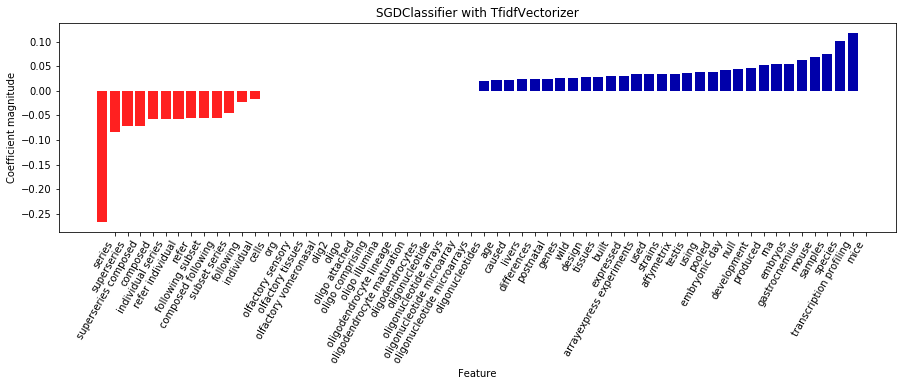

In [66]:
mglearn.tools.visualize_coefficients(
    trainedCLF.named_steps["sgd"].coef_, 
    feature_names, n_top_features=30
)
plt.title("SGDClassifier with TfidfVectorizer")

# TFIDF VECTORIZER w/ beta=2 

In [67]:
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import mglearn




clf=Pipeline([('cvect',TfidfVectorizer(strip_accents='ascii',token_pattern=u'(?u)\\b([a-z_]\w+)\\b',stop_words="english")),
              ('stdsclr',StandardScaler(copy=True,with_mean=False, with_std=True)),
              ('sgd',SGDClassifier(verbose=1,eta0=1,class_weight='balanced')),
])

parameters={ 'cvect__ngram_range':[(1,1),(1,2),(1,3)],
             'cvect__min_df':[2],
             'cvect__max_df':[.98],
             'sgd__eta0':[.001,.01,.1,1],
             'sgd__alpha':[.0001,.001,.01,.1],
             'sgd__loss':[ 'hinge', 'log','modified_huber'],
             'sgd__penalty':['l2','l1','elasticnet'],
             'sgd__n_iter':[5],
             'sgd__shuffle':[True,False],
             'sgd__learning_rate':['constant','invscaling'],
            
              
        }

beta=2
f_scorer=make_f_scorer(beta)

#Running GridSearch
gs_clf=GridSearchCV(clf,parameters,scoring=f_scorer,n_jobs=-1,verbose=1)
gs_clf=gs_clf.fit(docs_train,y_train)
trainedCLF=gs_clf.best_estimator_
vectorizer=gs_clf.best_estimator_.named_steps["cvect"]

print ("SGD Classifier with Tfidf Vectorizer: \n")
for param_name in sorted(parameters.keys()):
    print("%s:%r"%(param_name,gs_clf.best_params_[param_name]))
    print("\n")

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  7.2min finished


-- Epoch 1
Norm: 0.30, NNZs: 4507, Bias: -0.000110, T: 1784, Avg. loss: 0.797115
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.33, NNZs: 4370, Bias: -0.000206, T: 3568, Avg. loss: 0.641671
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.35, NNZs: 4258, Bias: -0.000260, T: 5352, Avg. loss: 0.549107
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.37, NNZs: 4185, Bias: -0.000292, T: 7136, Avg. loss: 0.486556
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 4134, Bias: -0.000317, T: 8920, Avg. loss: 0.441300
Total training time: 0.00 seconds.
SGD Classifier with Tfidf Vectorizer: 

cvect__max_df:0.98


cvect__min_df:2


cvect__ngram_range:(1, 1)


sgd__alpha:0.01


sgd__eta0:0.001


sgd__learning_rate:'invscaling'


sgd__loss:'hinge'


sgd__n_iter:5


sgd__penalty:'l1'




In [68]:
#vectorizer=gs_clf.best_estimator_.named_steps["cvect"]
y_test_predicted=trainedCLF.predict(docs_test)
y_train_predicted=trainedCLF.predict(docs_train)
#vectorizer=gs_clf.best_estimator_.named_steps["cvect"]
print results(y_test,y_test_predicted,y_train,y_train_predicted,beta)

Test Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.59      0.91      0.72       134
         no       0.97      0.82      0.89       461

avg / total       0.88      0.84      0.85       595

F 2: 0.821


[[122  12]
 [ 85 376]]


Training Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.75      1.00      0.86       352
         no       1.00      0.92      0.96      1432

avg / total       0.95      0.94      0.94      1784

F 2: 0.937
[[ 351    1]
 [ 114 1318]]
None


In [69]:
feature_names=np.array(vectorizer.get_feature_names())
print ("Number of Features: %d\n" % len(feature_names))
print  ("First ten features: {}\n".format(feature_names[0:10]))
middle_ten =len(feature_names)/2 +10 
print ("Middle ten features: {} \n".format(feature_names[len(feature_names)/2: middle_ten]))
print  ("Last ten features: {}\n".format(feature_names[-10:]))

print falselyReported(y_test, y_test_predicted, file_names_test)

Number of Features: 5322

First ten features: [u'a2' u'a_x0080__x0093_' u'a_x0084_s' u'a_x0088__x0092_' u'a_x0089_1'
 u'aa' u'aa4' u'abdominal' u'aberrant' u'aberrations']

Middle ten features: [u'ldb1' u'ldlr' u'ldp' u'lead' u'leading' u'leads' u'lean' u'learning'
 u'lectin' u'led'] 

Last ten features: [u'yy1' u'zebrafish' u'zinc' u'zone' u'zones' u'zooepidemicus' u'zscan4'
 u'zt20' u'zt6' u'zygotic']

total count:  97

Number of False Positves:  85
['E-GEOD-57311', 'E-GEOD-769', 'E-MTAB-1569', 'E-GEOD-31013', 'E-GEOD-26396', 'E-SMDB-24', 'E-GEOD-2882', 'E-GEOD-9033', 'E-GEOD-84371', 'E-GEOD-47395', 'E-GEOD-11897']

Number of False Negatives:  12
['E-GEOD-33979', 'E-GEOD-97', 'E-ERAD-283', 'E-GEOD-31234', 'E-GEOD-56135', 'E-GEOD-30198', 'E-ERAD-352', 'E-GEOD-10246', 'E-GEOD-60243', 'E-GEOD-47953', 'E-MTAB-3707']
None


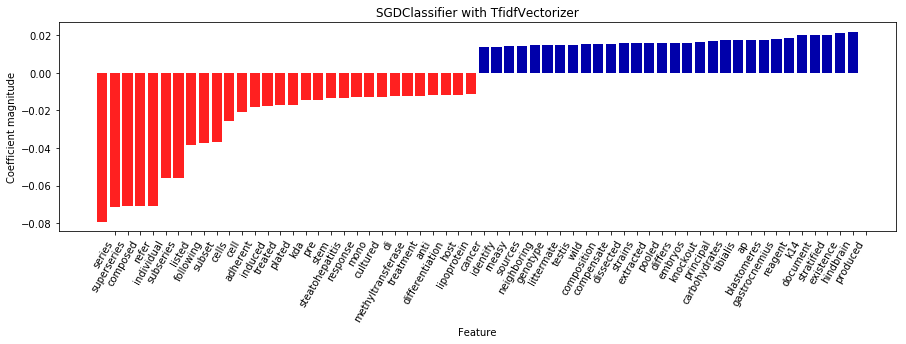

In [70]:
mglearn.tools.visualize_coefficients(
    trainedCLF.named_steps["sgd"].coef_, 
    feature_names, n_top_features=30
)
plt.title("SGDClassifier with TfidfVectorizer")

# TFIDF VECTORIZER w/ beta=3

In [82]:
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import mglearn




clf=Pipeline([('cvect',TfidfVectorizer(strip_accents='ascii',token_pattern=u'(?u)\\b([a-z_]\w+)\\b',stop_words="english")),
              ('stdsclr',StandardScaler(copy=True,with_mean=False, with_std=True)),
              ('sgd',SGDClassifier(verbose=1,eta0=1,class_weight='balanced')),
])

parameters={ 'cvect__ngram_range':[(1,1),(1,2),(1,3)],
             'cvect__min_df':[2],
             'cvect__max_df':[.98],
             'sgd__eta0':[.001,.01,.1,1],
             'sgd__alpha':[.0001,.001,.01,.1],
             'sgd__loss':[ 'hinge', 'log','modified_huber'],
             'sgd__penalty':['l2','l1','elasticnet'],
             'sgd__n_iter':[5],
             'sgd__shuffle':[True,False],
             'sgd__learning_rate':['constant','invscaling'],
            
              
        }

beta=3
f_scorer=make_f_scorer(beta)

#Running GridSearch
gs_clf=GridSearchCV(clf,parameters,scoring=f_scorer,n_jobs=-1,verbose=1)
gs_clf=gs_clf.fit(docs_train,y_train)
trainedCLF=gs_clf.best_estimator_
vectorizer=gs_clf.best_estimator_.named_steps["cvect"]

print ("SGD Classifier with Tfidf Vectorizer: \n")
for param_name in sorted(parameters.keys()):
    print("%s:%r"%(param_name,gs_clf.best_params_[param_name]))
    print("\n")

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed: 41.7min finished


-- Epoch 1
Norm: 2.84, NNZs: 6316, Bias: -0.000693, T: 1784, Avg. loss: 0.642276
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 3.12, NNZs: 2262, Bias: -0.001069, T: 3568, Avg. loss: 0.442179
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 3.34, NNZs: 1690, Bias: -0.001332, T: 5352, Avg. loss: 0.377039
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 3.50, NNZs: 1224, Bias: -0.001545, T: 7136, Avg. loss: 0.342955
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 3.57, NNZs: 873, Bias: -0.001825, T: 8920, Avg. loss: 0.323556
Total training time: 0.02 seconds.
SGD Classifier with Tfidf Vectorizer: 

cvect__max_df:0.98


cvect__min_df:2


cvect__ngram_range:(1, 3)


sgd__alpha:0.1


sgd__eta0:0.001


sgd__learning_rate:'constant'


sgd__loss:'log'


sgd__n_iter:5


sgd__penalty:'elasticnet'


sgd__shuffle:True




In [83]:
#vectorizer=gs_clf.best_estimator_.named_steps["cvect"]
y_test_predicted=trainedCLF.predict(docs_test)
y_train_predicted=trainedCLF.predict(docs_train)
#vectorizer=gs_clf.best_estimator_.named_steps["cvect"]
print results(y_test,y_test_predicted,y_train,y_train_predicted,beta)

Test Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.62      0.97      0.76       134
         no       0.99      0.83      0.90       461

avg / total       0.91      0.86      0.87       595

F 3: 0.918


[[130   4]
 [ 80 381]]


Training Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.73      1.00      0.84       352
         no       1.00      0.91      0.95      1432

avg / total       0.95      0.93      0.93      1784

F 3: 0.964
[[ 352    0]
 [ 131 1301]]
None


In [84]:
feature_names=np.array(vectorizer.get_feature_names())
print ("Number of Features: %d\n" % len(feature_names))
print  ("First ten features: {}\n".format(feature_names[0:10]))
middle_ten =len(feature_names)/2 +10 
print ("Middle ten features: {} \n".format(feature_names[len(feature_names)/2: middle_ten]))
print  ("Last ten features: {}\n".format(feature_names[-10:]))

print falselyReported(y_test, y_test_predicted, file_names_test)

Number of Features: 18859

First ten features: [u'a2' u'a_x0080__x0093_' u'a_x0080__x0093_ mice' u'a_x0084_s'
 u'a_x0088__x0092_' u'a_x0088__x0092_ mice' u'a_x0088__x0092_ mice bwa'
 u'a_x0088__x0092_ retina' u'a_x0088__x0092_ retina fold' u'a_x0089_1']

Middle ten features: [u'ko cell' u'ko cells' u'ko control' u'ko embryos' u'ko es' u'ko es cells'
 u'ko il6' u'ko il6 ko' u'ko ko' u'ko mdr2'] 

Last ten features: [u'zooepidemicus' u'zooepidemicus colony' u'zooepidemicus colony forming'
 u'zooepidemicus strongly' u'zooepidemicus strongly suggest' u'zscan4'
 u'zt20' u'zt6' u'zt6 zt20' u'zygotic']

total count:  84

Number of False Positves:  80
['E-GEOD-38001', 'E-GEOD-769', 'E-GEOD-77846', 'E-MTAB-3814', 'E-GEOD-31013', 'E-GEOD-2882', 'E-GEOD-9033', 'E-GEOD-47735', 'E-GEOD-47395', 'E-GEOD-15729', 'E-GEOD-66420']

Number of False Negatives:  4
['E-ERAD-283', 'E-GEOD-36026', 'E-MTAB-3707', 'E-MTAB-1035']
None


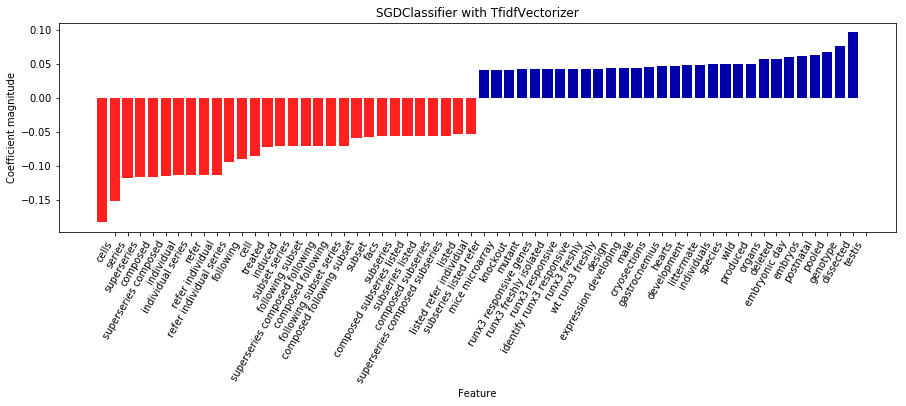

In [85]:
mglearn.tools.visualize_coefficients(
    trainedCLF.named_steps["sgd"].coef_, 
    feature_names, n_top_features=30
)
plt.title("SGDClassifier with TfidfVectorizer")

# TFIDF VECTORIZER W/ MaxAbsScaler 

In [76]:
#SGD Classifier with Tfidf Vectorizer 
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import mglearn
from sklearn.preprocessing import MaxAbsScaler
from sklearn import preprocessing




clf=Pipeline([('vect',TfidfVectorizer(strip_accents='ascii',token_pattern=u'(?u)\\b([a-z_]\w+)\\b',stop_words="english")),
              ('mas',MaxAbsScaler()),
              ('sgd',SGDClassifier(eta0=1,verbose=1,class_weight='balanced')),
])

parameters={ 'vect__ngram_range':[(1,1),(1,2),(1,3)],
             'vect__min_df':[2],
             'vect__max_df':[.98],
             'sgd__eta0':[.001,.01,.1,1],
             'sgd__alpha':[.0001,.001,.01,.1],
             'sgd__loss':[ 'hinge', 'log','modified_huber'],
             'sgd__penalty':['l2','l1','elasticnet'],
             'sgd__n_iter':[5],
             'sgd__shuffle':[True,False],
             'sgd__learning_rate':['constant','invscaling'],
              
            
              
        }

beta=4
f_scorer=make_f_scorer(beta)

#Running GridSearch
gs_clf=GridSearchCV(clf,parameters,scoring=f_scorer,n_jobs=-1)
gs_clf=gs_clf.fit(docs_train,y_train)
trainedCLF=gs_clf.best_estimator_
vectorizer=gs_clf.best_estimator_.named_steps["vect"]

print ("SGD Classifier with Tfidf Vectorizer: \n")
for param_name in sorted(parameters.keys()):
    print("%s:%r"%(param_name,gs_clf.best_params_[param_name]))
    print("\n")

-- Epoch 1
Norm: 2.41, NNZs: 5317, Bias: -0.037080, T: 1784, Avg. loss: 0.601552
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 2.16, NNZs: 5322, Bias: -0.051776, T: 3568, Avg. loss: 0.544851
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 2.11, NNZs: 5322, Bias: -0.061961, T: 5352, Avg. loss: 0.521435
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 2.01, NNZs: 5322, Bias: -0.071021, T: 7136, Avg. loss: 0.505301
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2.01, NNZs: 5322, Bias: -0.077930, T: 8920, Avg. loss: 0.496634
Total training time: 0.00 seconds.
SGD Classifier with Tfidf Vectorizer: 

sgd__alpha:0.1


sgd__eta0:1


sgd__learning_rate:'invscaling'


sgd__loss:'modified_huber'


sgd__n_iter:5


sgd__penalty:'l2'


sgd__shuffle:True


vect__max_df:0.98


vect__min_df:2


vect__ngram_range:(1, 1)




In [78]:
vectorizer=gs_clf.best_estimator_.named_steps["vect"]
y_test_predicted=trainedCLF.predict(docs_test)
y_train_predicted=trainedCLF.predict(docs_train)
vectorizer=gs_clf.best_estimator_.named_steps["vect"]
for param_name in sorted(parameters.keys()):
    print("%s:%r"%(param_name,gs_clf.best_params_[param_name]))
    print("\n")
print results(y_test,y_test_predicted,y_train,y_train_predicted,beta)

sgd__alpha:0.1


sgd__eta0:1


sgd__learning_rate:'invscaling'


sgd__loss:'modified_huber'


sgd__n_iter:5


sgd__penalty:'l2'


sgd__shuffle:True


vect__max_df:0.98


vect__min_df:2


vect__ngram_range:(1, 1)


Test Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.54      0.98      0.70       134
         no       0.99      0.76      0.86       461

avg / total       0.89      0.81      0.82       595

F 4: 0.933


[[131   3]
 [111 350]]


Training Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.58      0.99      0.73       352
         no       1.00      0.82      0.90      1432

avg / total       0.92      0.86      0.87      1784

F 4: 0.954
[[ 350    2]
 [ 252 1180]]
None


In [80]:
feature_names=np.array(vectorizer.get_feature_names())
print ("Number of Features:%d\n" % len(feature_names))
print  ("First ten features: {}\n".format(feature_names[0:10]))
middle_ten =len(feature_names)/2 +10 
print ("Middle ten features: {} \n".format(feature_names[len(feature_names)/2: middle_ten]))
print  ("First ten features: {}\n".format(feature_names[0:10]))

print falselyReported(y_test, y_test_predicted, file_names_test)

Number of Features:5322

First ten features: [u'a2' u'a_x0080__x0093_' u'a_x0084_s' u'a_x0088__x0092_' u'a_x0089_1'
 u'aa' u'aa4' u'abdominal' u'aberrant' u'aberrations']

Middle ten features: [u'ldb1' u'ldlr' u'ldp' u'lead' u'leading' u'leads' u'lean' u'learning'
 u'lectin' u'led'] 

First ten features: [u'a2' u'a_x0080__x0093_' u'a_x0084_s' u'a_x0088__x0092_' u'a_x0089_1'
 u'aa' u'aa4' u'abdominal' u'aberrant' u'aberrations']

total count:  114

Number of False Positves:  111
['E-GEOD-38001', 'E-GEOD-769', 'E-GEOD-77846', 'E-MTAB-3814', 'E-MTAB-1569', 'E-GEOD-31013', 'E-SMDB-24', 'E-GEOD-2882', 'E-GEOD-52416', 'E-GEOD-9033', 'E-GEOD-47735']

Number of False Negatives:  3
['E-ERAD-283', 'E-MTAB-3707', 'E-MTAB-1035']
None


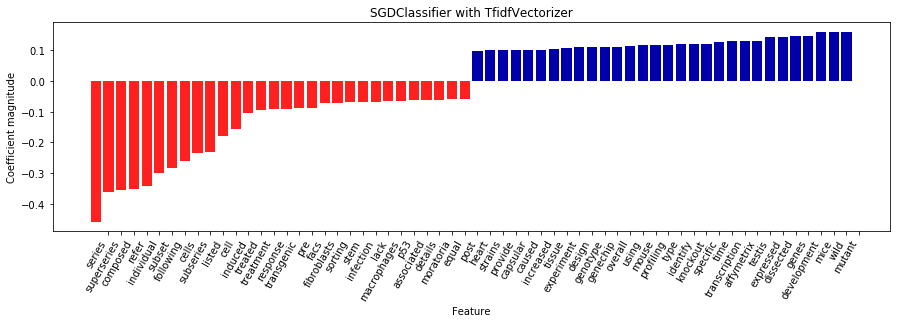

In [81]:
mglearn.tools.visualize_coefficients(
    trainedCLF.named_steps["sgd"].coef_, 
    feature_names, n_top_features=30
)
plt.title("SGDClassifier with TfidfVectorizer")